In [102]:
import pandas as pd      # for reading dataset
import numpy as np       # for array manipulation
import metis             # for metis.part_graph(graph, nparts=2, tpwgts=None, ubvec=None, recursive=False, **opts)
import matplotlib.pyplot as plt  # for plotting clusters
from tqdm import tqdm    # for output, it shows progress
import networkx as nx    # for graph, nx.Graph()
import itertools         # for iteration

In [103]:
# it finds euclidean distance between two points
def euclidean_distance(pointA, pointB):
    distance = np.linalg.norm(np.array(pointA) - np.array(pointB))
    return distance

# it constructs k-nearest neighbors (knn) graph
def create_knn_graph(dataset, k):
    points = [p[1:] for p in dataset.itertuples()]
    graph = nx.Graph()
    for i in range(0, len(points)):
        graph.add_node(i)
    print("Creating KNN graph (k = %d) : " % (k))
    iterpoints = tqdm(enumerate(points), total=len(points))
    for i, p in iterpoints:
        distances = list(map(lambda x: euclidean_distance(p, x), points))
        closests = np.argsort(distances)[1:k+1]  # second trough kth closest
        for c in closests:
            graph.add_edge(i, c, weight=1.0 / distances[c], similarity=int(1.0 / distances[c] * 1e4))
        graph.node[i]['pos'] = p
    return graph

# for partition the graph
def partition_graph(graph, c2, dataset=None):
    print("Start chameleon clustering : ")
    clusters = 0
    for i, p in enumerate(graph.nodes()):
        graph.node[p]['cluster'] = 0
    arr = {}
    arr[0] = len(graph.nodes())
    while clusters < c2 - 1:
        maxc = -1
        maxcnt = 0
        for key, val in arr.items():
            if val > maxcnt:
                maxcnt = val
                maxc = key
        s_nodes = [n for n in graph.node if graph.node[n]['cluster'] == maxc]
        s_graph = graph.subgraph(s_nodes)
        edgecuts, parts = metis.part_graph(s_graph, 2, objtype='cut', ufactor=250)
        new_cnt = 0
        for i, p in enumerate(s_graph.nodes()):
            if parts[i] == 1:
                graph.node[p]['cluster'] = clusters + 1
                new_cnt = new_cnt + 1
        arr[maxc] = arr[maxc] - new_cnt
        arr[clusters + 1] = new_cnt
        clusters = clusters + 1
    edgecuts, parts = metis.part_graph(graph, c2)
    if dataset is not None:
        dataset['cluster'] = nx.get_node_attributes(graph, 'cluster').values()
    return graph

# it uses metis.part_graph()
def part_graph(graph, k, dataset=None):
    edgecuts, parts = metis.part_graph( graph, 2, objtype='cut', ufactor=250) # metis.part_graph(graph, nparts=2, tpwgts=None, ubvec=None, recursive=False, **opts)
    for i, p in enumerate(graph.nodes()):
        graph.node[p]['cluster'] = parts[i]
    if dataset is not None:
        dataset['cluster'] = nx.get_node_attributes(graph, 'cluster').values()
    return graph

In [104]:
# it merges partition graph and creates final clusters
def merge_partition(graph, dataset, alpha, c1):
    clusters = np.unique(dataset['cluster'])
    max_score = 0
    ci, cj = -1, -1
    if len(clusters) <= c1:
        return False
    for combination in itertools.combinations(clusters, 2):
        i, j = combination
        if i != j:
            gi = get_cluster(graph, [i])
            gj = get_cluster(graph, [j])
            edges = edge_connection( (gi, gj), graph)
            if not edges:
                continue
            ms = merge(graph, gi, gj, alpha)
            if ms > max_score:
                max_score = ms
                ci, cj = i, j
    if max_score > 0:
        dataset.loc[dataset['cluster'] == cj, 'cluster'] = ci
        for i, p in enumerate(graph.nodes()):
            if graph.node[p]['cluster'] == cj:
                graph.node[p]['cluster'] = ci

def get_cluster(graph, clusters):
    nodes = [n for n in graph.node if graph.node[n]['cluster'] in clusters]
    return nodes

def edge_connection(partitions, graph):
    arr = []
    for a in partitions[0]:
        for b in partitions[1]:
            if a in graph:
                if b in graph[a]:
                    arr.append((a, b))
    return arr

# Chameleon determines the similarity between each pair of clusters Ci and Cj according to their relative interconnectivity RI(Ci, Cj), and their relative closeness RC(Ci, Cj).
def merge(graph, ci, cj, alpha):
    return relative_interconnectivity(graph, ci, cj) * np.power(relative_closeness(graph, ci, cj), alpha)

# RI(Ci, Cj) between two clusters, Ci and Cj , is defined as the absolute interconnectivity between Ci and Cj , normalized with respect to the internal interconnectivity of the two clusters, Ci and Cj.
def relative_interconnectivity(graph, ci, cj):
    edges = edge_connection((ci, cj), graph)
    EC = np.sum(get_weights(graph, edges))
    ECci, ECcj = internal_interconnectivity(graph, ci), internal_interconnectivity(graph, cj)
    return EC / ((ECci + ECcj) / 2.0)

# it uses formula in the book to calculate internal interconnectivity
def internal_interconnectivity(graph, cluster):
    return np.sum(bisection_weights(graph, cluster))

# RC(Ci, Cj) between a pair of clusters, Ci and Cj, is the absolute closeness between Ci and Cj, normalized with respect to the internal closeness of the two clusters, Ci and Cj.
def relative_closeness(graph, ci, cj):
    edges = edge_connection((ci, cj), graph)
    if not edges:
        return 0.0
    else:
        SEC = np.mean(get_weights(graph, edges))
    Ci, Cj = internal_closeness(graph, ci), internal_closeness(graph, cj)
    SECci, SECcj = np.mean(bisection_weights(graph, ci)), np.mean(bisection_weights(graph, cj))
    return SEC / ((Ci / (Ci + Cj) * SECci) + (Cj / (Ci + Cj) * SECcj))

def bisection_weights(graph, cluster):
    cluster = graph.subgraph(cluster)
    edges = min_cut_bisector(cluster)
    weights = get_weights(cluster, edges)
    return weights

def min_cut_bisector(graph):
    graph = graph.copy()
    graph = part_graph(graph, 2)
    partitions = get_cluster(graph, [0]), get_cluster(graph, [1])
    return edge_connection(partitions, graph)

def get_weights(graph, edges):
    return [graph[edge[0]][edge[1]]['weight'] for edge in edges]

def internal_closeness(graph, cluster):
    cluster = graph.subgraph(cluster)
    edges = cluster.edges()
    weights = get_weights(cluster, edges)
    return np.sum(weights)

def edit_labels(dataset):
    copy = dataset.copy()
    clusters = list(pd.DataFrame(dataset['cluster'].value_counts()).index)
    c = 1
    for i in clusters:
        copy.loc[dataset['cluster'] == i, 'cluster'] = c
        c = c + 1
    return copy

In [105]:
# for plotting clusters
def visualization(dataset):
    print("Visualization : ")
    dataset.plot(kind='scatter', c=dataset['cluster'], cmap='gist_rainbow', x=0, y=1)
    plt.show()

In [106]:
# it performs chameleon clustering technique and calls helper functions
def chameleon_clustering():
    knn=5    # number of neighbors looked when building knn
    c1=5
    c2=20
    alpha=2
    dataset = pd.read_csv('agg.csv', sep=' ',header=None)
    graph = create_knn_graph(dataset, knn)
    graph = partition_graph(graph, c2, dataset)
    progress = tqdm(enumerate(range(c2 - c1)), total=c2-c1) # tqdm shows progress, cluster numbers
    for i in progress:
        merge_partition(graph, dataset, alpha, c1)
#        res = edit_labels(dataset)
#        visualization(res)
    res = edit_labels(dataset)
    visualization(res)
################
    knn=30
    c1=5
    c2=20
    alpha=2
    graph = create_knn_graph(dataset, knn)
    graph = partition_graph(graph, c2, dataset)
    progress = tqdm(enumerate(range(c2 - c1)), total=c2-c1)
    for i in progress:
        merge_partition(graph, dataset, alpha, c1)
    res = edit_labels(dataset)
    visualization(res)
################
    knn=50
    c1=5
    c2=20
    alpha=2
    graph = create_knn_graph(dataset, knn)
    graph = partition_graph(graph, c2, dataset)
    progress = tqdm(enumerate(range(c2 - c1)), total=c2-c1)
    for i in progress:
        merge_partition(graph, dataset, alpha, c1)
    res = edit_labels(dataset)
    visualization(res)

Creating KNN graph (k = 5) : 


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 302.10it/s]


Start chameleon clustering : 


100%|███████████████████████████████████████████| 15/15 [00:05<00:00,  2.62it/s]


Visualization : 


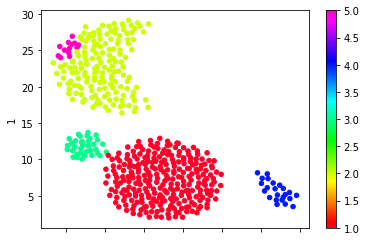

Creating KNN graph (k = 30) : 


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 294.27it/s]


Start chameleon clustering : 


100%|███████████████████████████████████████████| 15/15 [00:15<00:00,  1.03s/it]


Visualization : 


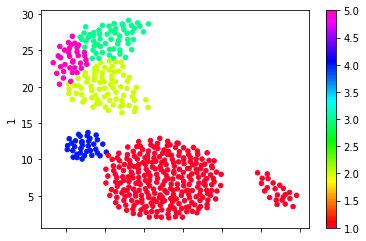

Creating KNN graph (k = 50) : 


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 273.12it/s]


Start chameleon clustering : 


100%|███████████████████████████████████████████| 15/15 [00:17<00:00,  1.19s/it]


Visualization : 


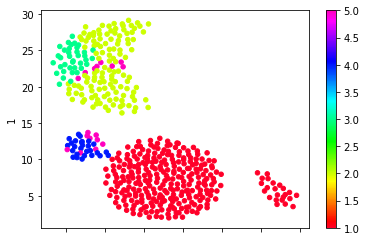

In [108]:
chameleon_clustering()